<a href="https://colab.research.google.com/github/quantaosun/Free_Cloud_Docking/blob/main/Flexible_docking_MD_mmpbsa_0626_nightly_built.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is to address the flexible binding of one small molecules towards a protein targets.Input are one SMILES strings and PDB code of a protein crystal of interest, output are a top scored binding pose and MMPBSA based affinties.
Stage 1 docking > Stage 2 MD > Stage 3 IFD > Stage 4 MD> MMGBSA(PBSA) > bing free energe estimation.

In [2]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
%%capture
import sys
!pip -q install py3Dmol 2>&1 1>/dev/null
!pip install --upgrade MDAnalysis 2>&1 1>/dev/null
!pip install git+https://github.com/pablo-arantes/biopandas 2>&1 1>/dev/null
!pip install rdkit-pypi
!pip install Cython
!git clone https://github.com/chemosim-lab/ProLIF.git
prolif1 = "cd /content/ProLIF"
prolif2 = "sed -i 's/mdanalysis.*/mdanalysis==2.0.0/' setup.cfg"
prolif3 = "pip install ."

original_stdout = sys.stdout # Save a reference to the original standard output

with open('prolif.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(prolif1)
    print(prolif2)
    print(prolif3)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 prolif.sh 2>&1 1>/dev/null
!bash prolif.sh >/dev/null 2>&1

# install conda
!wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh 
!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
!rm -r Miniconda3-latest-Linux-x86_64.sh /content/ProLIF prolif.sh
!conda install -y -q -c conda-forge openmm=7.6 python=3.7 pdbfixer 2>&1 1>/dev/null
!conda install -c conda-forge ambertools --yes 2>&1 1>/dev/null
!conda install -c ambermd pytraj  --yes 2>&1 1>/dev/null
!conda install -c conda-forge parmed  --yes 2>&1 1>/dev/null
!conda install -c conda-forge openff-toolkit --yes 2>&1 1>/dev/null
!conda install -c bioconda pybel --yes
!conda install -c openbabel openbabel --yes

#load dependencies
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
import parmed as pmd
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request  
import numpy as np
import MDAnalysis as mda
import py3Dmol
from __future__ import print_function
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats
!wget  https://raw.githubusercontent.com/openforcefield/openff-forcefields/master/openforcefields/offxml/openff_unconstrained-2.0.0.offxml 2>&1 1>/dev/null


# Copy  ligand smiles string from Chemdraw to here

In [4]:
#@title Install Conda Rdkit and Open Babel
#! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local &> /dev/null
#! conda install -c rdkit rdkit -y &> /dev/null
#!pip install py3Dmol
#!time conda install -q -y -c openbabel openbabel
#!!conda install -c schrodinger pymol -y
#!conda install 
#import sys
#sys.path.append('/usr/local/lib/python3.7/site-packages/')
!apt-get install pymol 2>&1 1>/dev/null


In [3]:
#@title Prepare visualization before docking
import sys
from collections import defaultdict
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
import pandas as pd

%pylab inline
IPythonConsole.ipython_3d = True

import py3Dmol
import matplotlib.pyplot as plt
import subprocess

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['tanh', 'copy', 'bar', 'bytes', 'sum', 'sqrt', 'mean', 'sin', 'f', 'tan', 'dot', 'norm', 'matrix', 'radians', 'byte', 'sinh', 'cos', 'degrees', 'cosh']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

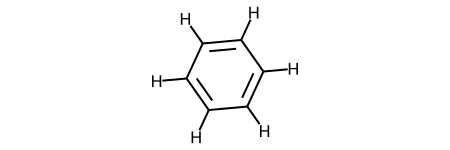

In [5]:
#@title Visualizatino of ligand 2
smiles = "c1ccccc1" #@param {type:"string"}
mol = Chem.MolFromSmiles(smiles) 
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)
mol

In [6]:
#@title  1）Convert SMILE strings to SDF format
Ligand_2 = "c1ccccc1" #@param {type:"string"}
!echo "{Ligand_2}" > ligand2.smi
!obabel ligand2.smi -osdf -O ligand2.sdf --gen3d

1 molecule converted


In [7]:
#@title Download and install software

!wget --no-check-certificate https://sourceforge.net/projects/smina/files/smina.static/download -O smina.static
!chmod u+x smina.static
!./smina.static -h
#!yes | /home/aistudio/external-libraries/bin/conda install -c conda-forge pymol-open-source 

--2022-06-26 13:13:12--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 104.18.34.243, 172.64.153.13
Connecting to sourceforge.net (sourceforge.net)|104.18.34.243|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABiuFtoqJTtBFTEIau-7187Dy7crSrsBJiK2xC_iW915ReQVJyshHosv5L0fQ_y50dPGIbrJC7JKlwLW848LPOjCsvupA%3D%3D&use_mirror=altushost-swe&r= [following]
--2022-06-26 13:13:12--  https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABiuFtoqJTtBFTEIau-7187Dy7crSrsBJiK2xC_iW915ReQVJyshHosv5L0fQ_y50dPGIbrJC7JKlwLW848LPOjCsvupA%3D%3D&use_mirror=altushost-swe&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://altushos

In [8]:
!pymol 

freeglut (pymol): failed to open display ''
 PyMOL: abrupt program termination.


# Provide protein targets 

In [9]:
#@title 👋 Download two protein targets about the Selectivity.

PDB_ID_2 = "3HTB" #@param {type:"string"}

pdb_2 = PDB_ID_2 + ".pdb"
! wget https://files.rcsb.org/download/$pdb_2


--2022-06-26 13:13:21--  https://files.rcsb.org/download/3HTB.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.158.66
Connecting to files.rcsb.org (files.rcsb.org)|128.6.158.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘3HTB.pdb’

3HTB.pdb                [  <=>               ] 161.13K   687KB/s    in 0.2s    

2022-06-26 13:13:21 (687 KB/s) - ‘3HTB.pdb’ saved [164997]



# Visit RCSB to find the Three-letter ligand code, substitute 567 with it
# Use the FOUR-letter pdb code to substitute 1234 below.

# Prepare Protein target 2

In [10]:
#@title Pymol Script_dock_without_water, replace 3HTB and JZ4 !
com_file = open('protein_2.pml','w')
com_file.write('''
load 3HTB.pdb
remove resn HOH
h_add elem O or elem N
select 3HTB-JZ4, resn JZ4 #Create a selection called 1OYT-FSN from the ligand
select 3HTB-receptor, 3HTB and not 3HTB-JZ4 #Select all that is not the ligand
save 3HTB-JZ4.pdb, 3HTB-JZ4
save 3HTB-receptor.pdb, 3HTB-receptor    
''')
com_file.close()

In [11]:
#@title Split Targets  before docking
%cd /content
! pymol -c protein_2.pml

/content
 PyMOL(TM) Molecular Graphics System, Version 1.8.4.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Command mode. No graphics front end.
 Detected 2 CPU cores.  Enabled multithreaded rendering.
PyMOL>load 3HTB.pdb
HEADER    HYDROLASE                               11-JUN-09   3HTB
TITLE     2-PROPYLPHENOL IN COMPLEX WITH T4 LYSOZYME L99A/M102Q

In [13]:
#@title Define ligand1 path and number
# File locations
sdfFilePath = 'ligand2.sdf' #@param {type:"string"}
ConfoutputFilePath = 'ligand2_conformation.sdf' #@param {type:"string"}

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

1

In [14]:
#@title Check names of SDF
for i, mol in enumerate(inputMols):
    if mol is None:
        print('Warning: Failed to read molecule %s in %s' % (i, sdfFilePath))
    if not mol.GetProp('_Name'):

        print('Warning: No name for molecule %s in %s' % (i, sdfFilePath))

In [15]:
#@title SDF conformation generation
import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time:  0:00:00 |###############################|


**Warning ☹ Always have a look to make sure there are no multimers, otherwise the docking will be problematic later.**

In [16]:
#@title 👋 Input names needed for ligand1 and Dyrk1A.
ProteinForDocking = "3HTB-receptor.pdb" #@param {type:"string"}
LigandFromProtein = "3HTB-JZ4.pdb" #@param {type:"string"}
Docked_out_FilePath = "ligand2_Docked_3HTB.sdf" #@param {type:"string"}
FlexibleDockedFilePath = "ligand2_FlexibleDocked_3HTB.sdf.gz" #@param {type:"string"}



# Stage 1

# Docking of protein 2 and ligand 1

In [17]:
#@title Define ligand1 path and number
# File locations
sdfFilePath = 'ligand2.sdf' #@param {type:"string"}
ConfoutputFilePath = 'ligand2_conformation.sdf' #@param {type:"string"}

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

1

In [18]:
#@title SDF conformation generation for ligand2

import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time:  0:00:00 |###############################|


In [19]:
#@title 👋 Input names needed for ligand2 and Dyrk1A.
ProteinForDocking = "3HTB-receptor.pdb" #@param {type:"string"}
LigandFromProtein = "3HTB-JZ4.pdb" #@param {type:"string"}
Docked_out_FilePath = "ligand2_Docked_3HTB.sdf" #@param {type:"string"}
FlexibleDockedFilePath = "ligands_FlexibleDocked_3HTB.sdf.gz" #@param {type:"string"}

In [20]:
!'./smina.static' --cpu 2 --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' -o '{Docked_out_FilePath}'

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -

# Post-dock processing, convert file format for visualization puroose，modify 4-letter code accordingly

In [23]:
!obabel -isdf ligand2_Docked_3HTB.sdf -opdb -O 2_1.pdb -m
!mkdir 2_1
!mv *2_1* 2_1/
!cp /content/3HTB-receptor.pdb 2_1/

9 molecules converted
9 files output. The first is 2_11.pdb
mkdir: cannot create directory ‘2_1’: File exists
mv: cannot move '2_1' to a subdirectory of itself, '2_1/2_1'


# Now you can download the top1 docked pdb from the docking, as representative binding modes. 

# Stage 2

# MD of Pro 2 and lig 1

In [24]:
#@title **Please, provide the necessary input files below**: 
#@markdown **Important:** The protonation of your ligand is crucial for the correct parameterization of the molecule.
%%capture
import pybel
import rdkit
import mdtraj as md
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole
from pdbfixer import PDBFixer

Protein_PDB_file_name = '3HTB-receptor.pdb' #@param {type:"string"}
Ligand_PDB_file_name = '2_11.pdb'  #@param {type:"string"}

Add_ligand_hydrogens = "Yes" #@param ["Yes", "No"]


ligand_name = Ligand_PDB_file_name
Google_Drive_Path = '/content/2_1' #@param {type:"string"}
workDir = Google_Drive_Path
file_name = os.path.join(workDir, str(Protein_PDB_file_name)) 
initial_pdb = os.path.join(workDir, "starting0.pdb")
ligand_pdb = os.path.join(workDir, str(ligand_name))
ligand_pdb2 = os.path.join(workDir, "ligand_H.pdb")
starting = os.path.join(workDir, "starting1.pdb")
starting2 = os.path.join(workDir, "starting2.pdb")
starting_end = os.path.join(workDir, "starting_end.pdb")

#Add hydrogens in the ligand
if Add_ligand_hydrogens == "Yes":
  fixer = PDBFixer(filename=ligand_pdb)
  PDBFile.writeFile(fixer.topology, fixer.positions, open("temp.pdb", 'w'))
  
  ppdb = PandasPdb().read_pdb("temp.pdb")
  ppdb.df['ATOM'] = ppdb.df['ATOM']
  ppdb.df['HETATM']= ppdb.df['HETATM'][ppdb.df['HETATM']['element_symbol'] != 'H']
  ppdb.to_pdb(path="temp.pdb", records=['ATOM', 'HETATM'], gz=False, append_newline=True)

  mol= [m for m in pybel.readfile(filename="temp.pdb", format='pdb')][0]
  mol.calccharges
  mol.addh()
  out=pybel.Outputfile(filename="temp2.pdb",format='pdb',overwrite=True)
  out.write(mol)
  out.close()

  md.load("temp2.pdb").save("temp2.pdb")
    
  halogens = ['Cl', 'F', 'Br', 'I']
  atom_id = []
  H_id = []
  with open("temp2.pdb") as f:
      for line in f:
        data = line.split()
        if data[0] == "ATOM":
          if data[2] in halogens:
            atom_id.append(data[1])
        if data[0] == "CONECT":
          if data[1] in atom_id:
            if len(data) > 3:
              H_id.append(data[3])
              H_id.append(data[4])
              H_id.append(data[5])

  with open(ligand_pdb2, 'w') as h:
    with open("temp2.pdb") as f:
      for line in f:
        data = line.split()
        if data[0] == "ATOM":
          if data[1] not in H_id:
            print(line, file=h)
        elif data[0] == "CONECT":
            if data[1] not in atom_id:
              print(line, file=h)
        else:
          print(line, file=h)

  fixer = PDBFixer(filename=ligand_pdb2)
  PDBFile.writeFile(fixer.topology, fixer.positions, open(ligand_pdb2, 'w'))

else:
  fixer = PDBFixer(filename=ligand_pdb)
  PDBFile.writeFile(fixer.topology, fixer.positions, open(ligand_pdb2, 'w'))

#Fix protein
pdb_parm = pmd.load_file(file_name)
pdb_parm.save(initial_pdb, standard_resnames=True, overwrite=True)

ppdb = PandasPdb().read_pdb(initial_pdb)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] == 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.df['ATOM']= ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']
ppdb.to_pdb(path=starting, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

from Bio.PDB import is_aa
from Bio.PDB import PDBParser, PDBIO, Select


class ProtSelect(Select):
    def accept_residue(self, residue):
        print(f"{residue} -> {is_aa(residue)}")
        return is_aa(residue, standard=True)


from Bio import PDB

pdb_ini = PDBParser().get_structure("pdb", starting)
io = PDBIO()
io.set_structure(pdb_ini)
io.save(starting2, ProtSelect());

pdb4amber_cmd = "pdb4amber -i " + str(starting2) + " -o " + str(starting_end) + " -p"
original_stdout = sys.stdout # Save a reference to the original standard output

with open('pdb4amber.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(pdb4amber_cmd)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 pdb4amber.sh 2>&1 1>/dev/null
!bash pdb4amber.sh 2> /dev/null

!rm pdb4amber.sh temp.pdb temp2.pdb

#@markdown ---

No chiral centres were identified! 
Isomer 1 = c1ccccc1


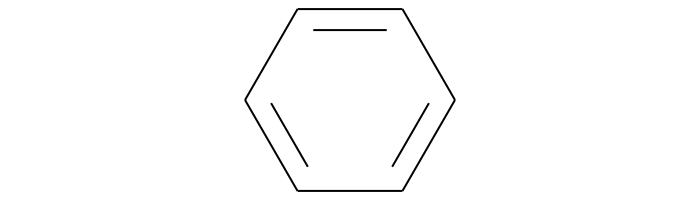

In [25]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole

#@title **Enumerate Stereoisomers to generate ligand topology:**

##@markdown **You can find the smiles for your lingad at: https://pubchem.ncbi.nlm.nih.gov/**

mol= [m for m in pybel.readfile(filename=ligand_pdb2, format='pdb')][0]
mol.calccharges
mol.addh()
out=pybel.Outputfile(filename="temp2.smi",format='smiles',overwrite=True)
out.write(mol)
out.close()

fileObj = open("temp2.smi", "r",) #opens the file in read mode
for aRow in fileObj:
    smi = aRow.split('\t')
fileObj.close()

Ligand_smiles = smi[0] 
!rm temp2.smi >/dev/null 2>&1

mol = Chem.MolFromSmiles(Ligand_smiles)

def spam(n):
    out=[]
    for perm in getPerms(n):
        elem = [ int(i) for i in list(perm) ]
        out.append(elem)
    return out

def getPerms(n):
    from itertools import permutations
    for i in getCandidates(n):
        for perm in set(permutations(i)):
            yield ''.join(perm)

def getCandidates(n):
    for i in range(0, n+1):
        res = "1" * i + "0" * (n - i)
        yield res

def GetStereoIsomers(mol):
    from rdkit import Chem
    from copy import copy
    out = []   

    chiralCentres = Chem.FindMolChiralCenters(mol, includeUnassigned=True)

    #return the molecule object when no chiral centres where identified
    if chiralCentres == []:
        return [mol]

      #All bit permutations with number of bits equals number of chiralCentres
    elements = spam(len(chiralCentres))
    !rm smiles.txt temp2.smi >/dev/null 2>&1
    for isoId,element in enumerate(elements):       
        for centreId,i in enumerate(element):
            atomId = chiralCentres[centreId][0]
            if i == 0:
                mol.GetAtomWithIdx(atomId).SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW)
            elif i == 1:
                mol.GetAtomWithIdx(atomId).SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW)
        outmol = copy(mol)
        out.append(outmol)
        print(Chem.MolToSmiles(mol,isomericSmiles=True), file=open("smiles.txt", "a",))
    return out

Draw.MolsToGridImage(GetStereoIsomers(mol), subImgSize=(500,200), molsPerRow=1)
chiralCentres = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
if chiralCentres != []:
  print("Follow the stereoisomers for your ligand: \n")
  fileObj = open("smiles.txt", "r",) #opens the file in read mode
  smiles = fileObj.read().splitlines() #puts the file into an array
  fileObj.close()
  x = len(smiles[:-1])
  for a in range(x+1):
    y = smiles[0+a:(a+1)]
    globals()[f"isomer{a+1}"] = str(y[0])
    print("Isomer " + str(a+1) + " = " + str(y[0]) + "\n")
else:
  isomer1 = Ligand_smiles
  print("No chiral centres were identified! \nIsomer 1 = " + str(isomer1)  )
Draw.MolsToGridImage(GetStereoIsomers(mol), subImgSize=(700,200), molsPerRow=1, returnPNG=True)

In [26]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from openff.toolkit.typing.engines.smirnoff import ForceField
import parmed

#@title **Parameters to generate the topology:**

#@markdown **Parameters to generate the protein topology:**

Force_field = "ff19SB" #@param ["ff19SB", "ff14SB"]
if Force_field == "ff19SB":
  ff = "leaprc.protein.ff19SB"
else:
  ff = "leaprc.protein.ff14SB"

Water_type = "TIP3P" #@param ["TIP3P", "OPC"]
if Water_type == "TIP3P":
  water = "leaprc.water.tip3p"
  water_box = "TIP3PBOX"
else:
  water = "leaprc.water.opc"
  water_box = "OPCBOX"

#@markdown Size Box (Angstrons):

Size_box = 12 #@param {type:"slider", min:10, max:20, step:1}
size_box = Size_box

#@markdown **ATTENTION**: Give the concentration in Molar units, AMBER tleap will neutralize your system automatically:

Ions = "NaCl" #@param ["NaCl", "KCl" ]

Concentration = "0.15" #@param {type:"string"}

#@markdown **Parameters to generate the ligand topology:**

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

Ligand_isomer = "1" #@param {type:"string", min:1, max:10, step:100}
if chiralCentres == []:
  isomer_end = isomer1
else:
  isomer_end = globals()[f"isomer{Ligand_isomer}"]

Ligand_net_charges = "0" #@param {type:"string", min:-10, max:10, step:1}

#@markdown ---
tleap = os.path.join(workDir, "tleap.in")
top_nw = os.path.join(workDir, "SYS_nw.prmtop")
crd_nw = os.path.join(workDir, "SYS_nw.crd")
pdb_nw = os.path.join(workDir, "SYS_nw.pdb")
top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")
ligand_noh = os.path.join(workDir, "ligand_noh.pdb")
ligand_h = os.path.join(workDir, "ligand_h.pdb")
ligand_mol2 = os.path.join(workDir, "ligand.mol2")
ligand_frcmod = os.path.join(workDir, "ligand.frcmod")
lig_new = os.path.join(workDir, "ligand_gaff.pdb")
protein_ligand = os.path.join(workDir, "protein_ligand.pdb")
lib = os.path.join(workDir, "lig.lib")

#gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command3 = "antechamber -i " + str(ligand_h) + " -fi pdb -o " + str(ligand_mol2) + " -fo mol2 -c bcc -nc " + str(Ligand_net_charges) + " -rn LIG -at gaff2"
gaff_command4 = "parmchk2 -i " + str(ligand_mol2) + " -f mol2 -o " + str(ligand_frcmod) + " -s gaff2"

original_stdout = sys.stdout # Save a reference to the original standard output

with open('gaff.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(gaff_command1)
    print(gaff_command3)
    print(gaff_command4)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 gaff.sh 2>&1 1>/dev/null
!bash gaff.sh >/dev/null 2>&1

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.gaff2
LIG = loadmol2 """ + str(ligand_mol2) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""saveoff LIG """ + str(lib) + "\n"
"""savepdb LIG """ + str(lig_new) + "\n" 
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)
cat_command = "cat " + str(starting_end) + " " + str(lig_new) + str(" > ") + str(protein_ligand)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    print(cat_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

ppdb = PandasPdb().read_pdb(protein_ligand)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['OTHERS'] = [ppdb.df['OTHERS'] != 'OTHERS']
ppdb.to_pdb(path=protein_ligand, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1 
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n" 
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7
saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

SYS = os.path.join(workDir, "SYS*")
rm_sys = "rm " + SYS

original_stdout = sys.stdout # Save a reference to the original standard output

with open('rm_sys.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(rm_sys)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 rm_sys.sh 2>&1 1>/dev/null
!bash rm_sys.sh 2> /dev/null

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null


!grep "Volume:" leap.log > temp.txt
with open("temp.txt", 'r') as f:
  for line in f:
        vol = float(line.split()[1])

vol_lit  = vol * pow(10, -27)
atom_lit = 9.03 * pow(10, 22)
conc = float(Concentration)
num_ion = int(vol_lit * (conc/0.15) * atom_lit)

if Ions == "NaCl":
  pos_neut = "Na+ 0"
  pos_num = "Na+ " + str(num_ion)
  Cl_num = num_ion
else:
  pos_neut = "K+ 0"
  pos_num = "K+ " + str(num_ion)
  Cl_num = num_ion

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1 
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n" 
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
check SYS 
charge SYS
addions SYS """ + str(pos_neut) + "\n"
"""addions SYS Cl- 0
check SYS
charge SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7 """ + "\n"
"""addIonsRand SYS """ + str(pos_num) + """ Cl- """ + str(Cl_num) + "\n"
"""saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()


!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  mol = Chem.MolFromPDBFile(lig_new, removeHs=False)
  Chem.MolToPDBFile(mol, os.path.join(workDir, "ligand_openFF.pdb"))
  
  in_prmtop = top
  in_crd = crd
  orig_structure = parmed.amber.AmberParm(in_prmtop, in_crd)
  pieces = orig_structure.split()
  for piece in pieces:
      print(f"There are {len(piece[1])} instance(s) of {piece[0]}")

  from openmm.app import PDBFile
  from openff.toolkit.topology import Molecule, Topology
  from openff.toolkit.tests.utils import get_data_file_path

  # rdmol = Chem.MolFromMolFile(os.path.join(workDir, "ligand_openFF.sdf"))
  # ligand_off_molecule = Molecule.from_rdkit(rdmol, hydrogens_are_explicit=True)

  ligand_off_molecule = Molecule.from_smiles(isomer_end)
  ligand_pdbfile = PDBFile(os.path.join(workDir, "ligand_openFF.pdb"))
  ligand_off_topology = Topology.from_openmm(
      ligand_pdbfile.topology,
      unique_molecules=[ligand_off_molecule],)

  force_field = ForceField("openff_unconstrained-2.0.0.offxml")

  ligand_system = force_field.create_openmm_system(ligand_off_topology)
  new_ligand_structure = parmed.openmm.load_topology(
      ligand_off_topology.to_openmm(),
      ligand_system,
      xyz=pieces[1][0].positions,)

  new_ligand_structure.save(os.path.join(workDir, "ligand.prmtop"), overwrite=True)
  new_ligand_structure.save(os.path.join(workDir, "ligand.inpcrd"), overwrite=True)

  # Check how many atoms and which order elements are in the new ligand
  n_atoms_new = len(new_ligand_structure.atoms)
  elements_new = [atom.element for atom in new_ligand_structure.atoms]

  # Check how many atoms and which order elements are in the old ligand
  old_ligand_structure, n_copies = pieces[1]
  n_atoms_old = len(old_ligand_structure.atoms)
  elements_old = [atom.element for atom in old_ligand_structure.atoms]

  print(
      f"There are {n_atoms_old} in the old ligand structure and {n_atoms_new} atoms "
      f"in the new ligand structure")

  # Print out error message if number of atoms doesn't match
  if n_atoms_new != n_atoms_old:
      print(
          "Error: Number of atoms in input ligand doesn't match number extracted "
          "from prmtop file.")

  if elements_new != elements_old:
      print(
          "Error: Elements in input ligand don't match elements in the ligand "
          "from the prmtop file.")
      print(f"Old elements: {elements_old}")
      print(f"New elements: {elements_new}")

  # Create a new, empty system
  complex_structure = parmed.Structure()

  # Add the protein. Convert explicitly to an AmberParm object to ensure that 1-4 scaling factors are preserved.
  complex_structure += parmed.amber.AmberParm.from_structure(pieces[0][0])

  # Add the ligand
  complex_structure += parmed.amber.AmberParm.from_structure(new_ligand_structure)

  # Add ions and Waters
  ppdb = PandasPdb().read_pdb(pdb)
  Cl = [ppdb.df['ATOM']['atom_name'] == 'Cl-']
  Na = [ppdb.df['ATOM']['atom_name'] == 'Na+']
  K = [ppdb.df['ATOM']['atom_name'] == 'K+']
  Cl = np.array(Cl)
  Na = np.array(Na)
  K = np.array(K)

  if True in Cl and True in Na:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    just_ion2_structure = parmed.Structure()
    just_ion2_structure += pieces[3][0]
    just_ion2_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)
    complex_structure += parmed.amber.AmberParm.from_structure(just_ion2_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[4][0]
    just_water_structure *= len(pieces[4][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Cl and True in K:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    just_ion2_structure = parmed.Structure()
    just_ion2_structure += pieces[3][0]
    just_ion2_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)
    complex_structure += parmed.amber.AmberParm.from_structure(just_ion2_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[4][0]
    just_water_structure *= len(pieces[4][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Cl:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Na:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in K:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  else: 
    just_water_structure = parmed.Structure()
    just_water_structure += pieces[2][0]
    just_water_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)

  # Copy over the original coordinates and box vectors
  complex_structure.coordinates = orig_structure.coordinates
  complex_structure.box_vectors = orig_structure.box_vectors

  # Export the Structure to AMBER files
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  complex_structure.save(top, overwrite=True)
  complex_structure.save(crd, overwrite=True)
  top_openff = os.path.exists(top)
  crd_openff = os.path.exists(crd)
  if top_openff == True and crd_openff == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")

else:
  pdb_amber = os.path.exists(pdb)
  top_amber = os.path.exists(top)
  crd_amber = os.path.exists(crd)

  if pdb_amber == True and top_amber == True and crd_amber == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")
!!rm *.sh  ANTECHAMBER* ATOMTYPE* temp.txt >/dev/null 2>&1

Successfully generated topology! :-)


[]

In [27]:
#@title ### **Parameters for MD Equilibration protocol:**

# remove whitespaces
Jobname = 'prot_lig_equil' #@param {type:"string"}

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  pdb = os.path.join(workDir, "SYS.pdb")
else:
  top = os.path.join(workDir, "SYS_gaff2.prmtop")
  crd = os.path.join(workDir, "SYS_gaff2.crd")
  pdb = os.path.join(workDir, "SYS.pdb")


Minimization_steps = "20000" #@param ["1000", "5000", "10000", "20000", "50000", "100000"]

#@markdown Simulation time (in nanoseconds) and integration time (in femtoseconds): 
Time = "0.2" #@param {type:"string"}
stride_time_eq = Time
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_eq = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_eq = Temperature
Pressure = 1 #@param {type:"string"}
pressure_eq = Pressure

#@markdown Position restraints force constant (in kJ/mol): 
Force_constant = 700 #@param {type:"slider", min:0, max:2000, step:100}

#@markdown Frequency to write the trajectory file (in picoseconds): 

Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_eq = Write_the_trajectory
#@markdown Frequency to write the log file (in picoseconds): 

Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log


#@markdown ---


In [28]:
#@title **Runs an Equilibration MD simulation (NPT ensemble)**
#@markdown Now, let's equilibrate our system!

###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, Jobname)
coordinatefile = crd
pdbfile = pdb
topologyfile = top

time_ps = float(Time)*1000
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond					
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

pressure	= float(pressure_eq)*bar

restraint_fc = int(Force_constant) # kJ/mol

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

def restraints(system, crd, fc, restraint_array):

	boxlx = system.getDefaultPeriodicBoxVectors()[0][0].value_in_unit(nanometers)
	boxly = system.getDefaultPeriodicBoxVectors()[1][1].value_in_unit(nanometers)
	boxlz = system.getDefaultPeriodicBoxVectors()[2][2].value_in_unit(nanometers)

	if fc > 0:
		# positional restraints for all heavy-atoms
		posresPROT = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2;')
		posresPROT.addPerParticleParameter('k')
		posresPROT.addPerParticleParameter('x0')
		posresPROT.addPerParticleParameter('y0')
		posresPROT.addPerParticleParameter('z0')
  
		for atom1 in restraint_array:
			atom1 = int(atom1)
               
			xpos  = crd.positions[atom1].value_in_unit(nanometers)[0]
			ypos  = crd.positions[atom1].value_in_unit(nanometers)[1]
			zpos  = crd.positions[atom1].value_in_unit(nanometers)[2]

			posresPROT.addParticle(atom1, [fc, xpos, ypos, zpos])
    
		system.addForce(posresPROT)

	return system
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(simulation_time))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps))

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)


print("\t- Applying restraints. Force Constant = " + str(Force_constant) + "kJ/mol")
pt_system = pt.iterload(coordinatefile, topologyfile)
pt_topology = pt_system.top
restraint_array = pt.select_atoms('!(:H*) & !(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+)', pt_topology)

system = restraints(system, inpcrd, restraint_fc, restraint_array)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

print("\t- Energy minimization: " + str(Minimization_steps) + " steps")
simulation.minimizeEnergy(tolerance=10*kilojoule/mole, maxIterations=int(Minimization_steps))
print("\t-> Potential Energy = " + str(simulation.context.getState(getEnergy=True).getPotentialEnergy()))

print("\t- Setting initial velocities...")
simulation.context.setVelocitiesToTemperature(temperature)

#############################################
# Running Equilibration on NPT ensemble

dcd_file = jobname + ".dcd"
log_file = jobname + ".log"
rst_file = jobname + ".rst"
prv_rst_file = jobname + ".rst"
pdb_file = jobname + ".pdb"

# Creating a trajectory file and reporters
dcd = DCDReporter(dcd_file, nsavcrd)
firstdcdstep = (nsteps) + nsavcrd
dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

simulation.reporters.append(dcd)
simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

print("\n> Simulating " + str(nsteps) + " steps...")
simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


##################################
# Writing last frame information of stride
print("\n> Writing state file (" + str(rst_file) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")


> Simulation details:

	Job name = /content/2_1/prot_lig_equil
	Coordinate file = /content/2_1/SYS_gaff2.crd
	PDB file = /content/2_1/SYS.pdb
	Topology file = /content/2_1/SYS_gaff2.prmtop

	Simulation_time = 200.0 ps
	Integration timestep = 2 fs
	Total number of steps = 100000

	Save coordinates each 10 ps
	Print in log file each 10 ps

	Temperature = 298.0 K
	Pressure = 1.0 bar

> Setting the system:

	- Reading topology and structure file...
	- Creating system and setting parameters...
	- Applying restraints. Force Constant = 700kJ/mol
	- Setting barostat...
	- Setting integrator...
	- Energy minimization: 20000 steps
	-> Potential Energy = -557782.7176482496 kJ/mol
	- Setting initial velocities...

> Simulating 100000 steps...
#"Progress (%)"		"Step"		"Speed (ns/day)"		"Time Remaining"
5.0%		5000		0		--
10.0%		10000		274		0:56
15.0%		15000		286		0:51
20.0%		20000		297		0:46
25.0%		25000		298		0:43
30.0%		30000		299		0:40
35.0%		35000		299		0:37
40.0%		40000		301		0:34
45.0%		45000

In [40]:
#@markdown ### **Provide input file names below:** 

Equilibrated_PDB = 'prot_lig_equil.pdb' #@param {type:"string"}
State_file = 'prot_lig_equil.rst' #@param {type:"string"}

#@markdown ---
#@markdown ### **Parameters for MD Production protocol:**


# remove whitespaces
Jobname = 'prot_lig_prod' #@param {type:"string"}

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  pdb = os.path.join(workDir, "SYS.pdb")

else:
  top = os.path.join(workDir, "SYS_gaff2.prmtop")
  crd = os.path.join(workDir, "SYS_gaff2.crd")
  pdb = os.path.join(workDir, "SYS.pdb")


#@markdown Simulation time (in nanoseconds), number of strides (integers) and integration timestep (in femtoseconds): 
Stride_Time = "0.2" #@param {type:"string"}
stride_time_prod = Stride_Time
Number_of_strides = "1" #@param {type:"string"}
nstride = Number_of_strides
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_prod = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_prod = Temperature
Pressure = 1 #@param {type:"string"}
pressure_prod = Pressure

#@markdown Frequency to write the trajectory file (in picoseconds): 
Write_the_trajectory = "100" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_prod = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds): 
Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_prod = Write_the_log

#@markdown ---

In [41]:
#@title **Runs a Production MD simulation (NPT ensemble) after equilibration**
#
###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, str(Jobname))
coordinatefile = crd
pdbfile = os.path.join(workDir, Equilibrated_PDB)
topologyfile = top
equil_rst_file = os.path.join(workDir, State_file)


stride_time_ps = float(stride_time_prod)*1000
stride_time = float(stride_time_ps)*picosecond        
nstride = int(Number_of_strides)
dt = int(dt_prod)*femtosecond					
temperature = float(temperature_prod)*kelvin
savcrd_freq = int(write_the_trajectory_prod)*picosecond
print_freq  = int(write_the_log_prod)*picosecond

pressure	= float(pressure_prod)*bar

simulation_time = stride_time*nstride
nsteps  = int(stride_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
firststride = 1 # must be integer
#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(stride_time*nstride))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps*nstride))
print("\tNumber of strides = " + str(nstride) + " (" + str(stride_time) + " in each stride)")

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tSave checkpoint each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
	simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

#############################################
# Opening a loop of extension NSTRIDE to simulate the entire STRIDE_TIME*NSTRIDE
for n in range(1, nstride + 1):

	print("\n\n>>> Simulating Stride #" + str(n) + " <<<")

	dcd_file = jobname + "_" + str(n) + ".dcd"
	log_file = jobname + "_" + str(n) + ".log"
	rst_file = jobname + "_" + str(n) + ".rst"
	prv_rst_file = jobname + "_" + str(n-1) + ".rst"
	pdb_file = jobname + "_" + str(n) + ".pdb"

	if os.path.exists(rst_file):
		print("> Stride #" + str(n) + " finished (" + rst_file + " present). Moving to next stride... <")
		continue

	if n == 1:
		print("\n> Loading previous state from equilibration > " + equil_rst_file + " <")
		with open(equil_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")

	else:
		print("> Loading previous state from > " + prv_rst_file + " <")
		with open(prv_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")


	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (currstep) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # first step should not be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=(nsteps*nstride), remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

	print("\n> Simulating " + str(nsteps) + " steps... (Stride #" + str(n) + ")")
	simulation.step(nsteps)

	simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


	##################################
	# Writing last frame information of stride
	print("\n> Writing state file (" + str(rst_file) + ")...")
	state = simulation.context.getState( getPositions=True, getVelocities=True )
	with open(rst_file, 'w') as f:
		f.write(XmlSerializer.serialize(state))

	last_frame = int(nsteps/nsavcrd)
	print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
	positions = simulation.context.getState(getPositions=True).getPositions()
	PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")


> Simulation details:

	Job name = /content/2_1/prot_lig_prod
	Coordinate file = /content/2_1/SYS_gaff2.crd
	PDB file = /content/2_1/prot_lig_equil.pdb
	Topology file = /content/2_1/SYS_gaff2.prmtop

	Simulation_time = 200.0 ps
	Integration timestep = 2 fs
	Total number of steps = 100000
	Number of strides = 1 (200.0 ps in each stride)

	Save coordinates each 100 ps
	Save checkpoint each 100 ps
	Print in log file each 10 ps

	Temperature = 298.0 K
	Pressure = 1.0 bar

> Setting the system:

	- Reading topology and structure file...
	- Creating system and setting parameters...
	- Setting barostat...
	- Setting integrator...


>>> Simulating Stride #1 <<<
> Stride #1 finished (/content/2_1/prot_lig_prod_1.rst present). Moving to next stride... <

> Finished!



In [42]:
#@title **Concatenate and align the trajectory**
Skip = "1" #@param ["1", "2", "5", "10", "20", "50"]
stride_traj = Skip
Output_format = "dcd" #@param ["dcd", "pdb", "trr", "xtc"]

#@markdown **Attention:** A high number of frames can explode the memory on Colab. You should be fine with 5000 frames or less.

simulation_time_analysis = stride_time_ps*nstride
simulation_ns = float(Stride_Time)*int(Number_of_strides)
number_frames = int(simulation_time_analysis)/int(Write_the_trajectory)
number_frames_analysis = number_frames/int(stride_traj)


traj_end = os.path.join(workDir, str(Jobname) + "_all.dcd")
traj_end2 = os.path.join(workDir, str(Jobname) + "_all." + str(Output_format))
template =  os.path.join(workDir, str(Jobname) + '_%s.dcd')

flist = [template % str(i) for i in range(1, nstride + 1)]
#print(flist)

trajlist = pt.load(flist, pdb, stride=stride_traj)
traj_image = trajlist.iterframe(autoimage=True, rmsfit=0)
traj_write = pt.write_traj(traj_end, traj_image, overwrite=True)
traj_load = pt.load(traj_end, pdb)
traj_align = pt.align(traj_load, mask="@CA", ref=0) 
traj_write = pt.write_traj(traj_end, traj_align, overwrite=True, options='dcd')
traj_write = pt.write_traj(traj_end2, traj_align, overwrite=True, options=Output_format)
traj_load = pt.load(traj_end, os.path.join(workDir, "SYS_gaff2.prmtop"))
print(traj_load)


traj_end_check = os.path.exists(traj_end2)

if traj_end_check == True:
  print("Trajectory concatenated successfully! :-)")
else:
  print("ERROR: Check your inputs! ")

pytraj.Trajectory, 2 frames: 
Size: 0.001481 (GB)
<Topology: 33129 atoms, 10381 residues, 10219 mols, PBC with box type = ortho>
           
Trajectory concatenated successfully! :-)


In [43]:
#@title **MM-PBSA method to calculate the binding free energy**
#@markdown **Important:** We will now calculate the interaction energy and solvation free energy for the complex, receptor and ligand and average the results to obtain an estimate of the binding free energy. Please note that we will not perform a calculation of the entropy contribution to binding and so strictly speaking our result will not be a true free energy but could be used to compare against similar systems. We will carry out the binding energy calculation using both the MM-GBSA method and the MM-PBSA method for comparison.

#@markdown Select the GB/SA input parameters,  the "OBC" models (igb=2 and 5) are newer, but appear to give significant improvements and are recommended for most projects (For more information check the Section 4.1 of the [Amber Manual](https://ambermd.org/doc12/Amber20.pdf)):
igb = "2" #@param ["0", "1", "2", "5", "6", "7", "8", "10"]

Salt_concentration = '0.15' #@param {type:"string"}

#@markdown **Provide output file names below:** 
Output_name = 'FINAL_RESULTS_MMPBSA' #@param {type:"string"}

final_mmpbsa = os.path.join(workDir, Output_name)

if number_frames_analysis > 10:
  stride = number_frames_analysis/10
else:
  stride = 1

f = open("mmpbsa.in", "w")
f.write("""&general """  + "\n"
"""  endframe=""" + str(int(number_frames_analysis)) + """,  interval=""" + str(int(stride)) + """, strip_mask=:WAT:Na+:Cl-:Mg+:K+, """ + "\n"
"""/ """ + "\n"
"""&gb """ + "\n"
""" igb=""" + str(igb) +  """, saltcon=""" + str(Salt_concentration) +  """, """ + "\n"
"""/ """ + "\n"
"""&pb """ + "\n"
""" istrng=""" + str(Salt_concentration) +  """, inp=2, radiopt=0, prbrad=1.4, """ + "\n"
"""/""")
f.close()

amberhome = "source /usr/local/amber.sh"
ante_MMPBSA = "ante-MMPBSA.py  -p " + os.path.join(workDir, "SYS_gaff2.prmtop") + " -c com.prmtop -r rec.prmtop -l ligand.prmtop -s :WAT:Na+:Cl-:Mg+:K+ -n :LIG --radii mbondi2" 
MMPBSA = "MMPBSA.py -O -i mmpbsa.in -o " + str(final_mmpbsa) +  ".dat -sp " + os.path.join(workDir, "SYS_gaff2.prmtop") + " -cp com.prmtop -rp rec.prmtop -lp ligand.prmtop -y "  + str(traj_end)
mkdir = "mkdir " + os.path.join(workDir, "MMPBSA")
mv = "mv _MMPBSA* *.prmtop reference.frc mmpbsa.in " + os.path.join(workDir, "MMPBSA")

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_MMPBSA.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(amberhome)
    print(ante_MMPBSA)
    print(MMPBSA)
    print(mkdir)
    print(mv)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_MMPBSA.sh 2>&1 1>/dev/null
!bash run_MMPBSA.sh 2>&1 1>/dev/null

f_mmpbsa = open(final_mmpbsa + '.dat', 'r')
file_contents = f_mmpbsa.read()
print(file_contents)
f_mmpbsa.close()

mkdir: cannot create directory ‘/content/2_1/MMPBSA’: File exists
| Run on Sun Jun 26 13:30:08 2022
|
|Input file:
|--------------------------------------------------------------
|&general 
|  endframe=2,  interval=1, strip_mask=:WAT:Na+:Cl-:Mg+:K+, 
|/ 
|&gb 
| igb=2, saltcon=0.15, 
|/ 
|&pb 
| istrng=0.15, inp=2, radiopt=0, prbrad=1.4, 
|/--------------------------------------------------------------
|MMPBSA.py Version=14.0
|Solvated complex topology file:  /content/2_1/SYS_gaff2.prmtop
|Complex topology file:           com.prmtop
|Receptor topology file:          rec.prmtop
|Ligand topology file:            ligand.prmtop
|Initial mdcrd(s):                /content/2_1/prot_lig_prod_all.dcd
|
|Receptor mask:                  ":1-163"
|Ligand mask:                    ":164"
|Ligand residue name is "LIG"
|
|Calculations performed using 2.0 complex frames.
|Poisson Boltzmann calculations performed using internal PBSA solver in mmpbsa_py_energy
|
|Generalized Born ESURF calculated using '

# Stage 3

# Flexible self dock 2_1
prot_lig_prod_1.pdb is the last frame of trajectory, so we will just use this to do the flexible docking.

In [52]:
%cd /content/2_1

/content/2_1


In [54]:
!grep ATOM prot_lig_prod_1.pdb > protein_1_1.pdb
!grep LIG prot_lig_prod_1.pdb > ligand_1_1.pdb

In [55]:
#@title Modified on 26 June 2022
!obabel ligand_1_1.pdb -osdf -O ligand2.sdf --gen3d

1 molecule converted


In [56]:
#@title Define ligand1 path and number
# File locations
sdfFilePath = 'ligand2.sdf' #@param {type:"string"}
ConfoutputFilePath = 'ligand2_conformation.sdf' #@param {type:"string"}

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

1

In [57]:
#@title Check names of SDF
for i, mol in enumerate(inputMols):
    if mol is None:
        print('Warning: Failed to read molecule %s in %s' % (i, sdfFilePath))
    if not mol.GetProp('_Name'):

        print('Warning: No name for molecule %s in %s' % (i, sdfFilePath))

In [58]:
#@title SDF conformation generation
import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time:  0:00:00 |###############################|


**Warning ☹ Always have a look to make sure there are no multimers, otherwise the docking will be problematic later.**

In [59]:
#@title 👋 Input names needed for ligand1 and Dyrk1A.
ProteinForDocking = "protein_1_1.pdb" #@param {type:"string"}
LigandFromProtein = "ligand_1_1.pdb" #@param {type:"string"}
Docked_out_FilePath = "ligand2_Docked_3HTB.sdf" #@param {type:"string"}
FlexibleDockedFilePath = "ligand2_FlexibleDocked_3HTB.sdf.gz" #@param {type:"string"}



In [66]:
!'/content/smina.static' --cpu 2 --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' --flexdist_ligand '{ConfoutputFilePath}' --flexdist 5 -o '{Docked_out_FilePath}'

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -

# Post-dock processing, convert file format for visualization puroose，modify 4-letter code accordingly

In [67]:
!obabel -isdf ligand2_Docked_3HTB.sdf -opdb -O 2_1.pdb -m
!mkdir 2_1
!mv *2_1* 2_1/
!cp /content/2_1/protein_1_1.pdb 2_1/

9 molecules converted
9 files output. The first is 2_11.pdb
mv: cannot move '2_1' to a subdirectory of itself, '2_1/2_1'


# Stage 4

# MD of IFD Pro 2 and lig 1

In [68]:
#@title **Please, provide the necessary input files below**: 
#@markdown **Important:** The protonation of your ligand is crucial for the correct parameterization of the molecule.
%%capture
import pybel
import rdkit
import mdtraj as md
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole
from pdbfixer import PDBFixer

Protein_PDB_file_name = '/content/2_1/2_1/protein_1_1.pdb' #@param {type:"string"}
Ligand_PDB_file_name = '2_11.pdb'  #@param {type:"string"}

Add_ligand_hydrogens = "Yes" #@param ["Yes", "No"]


ligand_name = Ligand_PDB_file_name
Google_Drive_Path = '/content/2_1/2_1' #@param {type:"string"}
workDir = Google_Drive_Path
file_name = os.path.join(workDir, str(Protein_PDB_file_name)) 
initial_pdb = os.path.join(workDir, "starting0.pdb")
ligand_pdb = os.path.join(workDir, str(ligand_name))
ligand_pdb2 = os.path.join(workDir, "ligand_H.pdb")
starting = os.path.join(workDir, "starting1.pdb")
starting2 = os.path.join(workDir, "starting2.pdb")
starting_end = os.path.join(workDir, "starting_end.pdb")

#Add hydrogens in the ligand
if Add_ligand_hydrogens == "Yes":
  fixer = PDBFixer(filename=ligand_pdb)
  PDBFile.writeFile(fixer.topology, fixer.positions, open("temp.pdb", 'w'))
  
  ppdb = PandasPdb().read_pdb("temp.pdb")
  ppdb.df['ATOM'] = ppdb.df['ATOM']
  ppdb.df['HETATM']= ppdb.df['HETATM'][ppdb.df['HETATM']['element_symbol'] != 'H']
  ppdb.to_pdb(path="temp.pdb", records=['ATOM', 'HETATM'], gz=False, append_newline=True)

  mol= [m for m in pybel.readfile(filename="temp.pdb", format='pdb')][0]
  mol.calccharges
  mol.addh()
  out=pybel.Outputfile(filename="temp2.pdb",format='pdb',overwrite=True)
  out.write(mol)
  out.close()

  md.load("temp2.pdb").save("temp2.pdb")
    
  halogens = ['Cl', 'F', 'Br', 'I']
  atom_id = []
  H_id = []
  with open("temp2.pdb") as f:
      for line in f:
        data = line.split()
        if data[0] == "ATOM":
          if data[2] in halogens:
            atom_id.append(data[1])
        if data[0] == "CONECT":
          if data[1] in atom_id:
            if len(data) > 3:
              H_id.append(data[3])
              H_id.append(data[4])
              H_id.append(data[5])

  with open(ligand_pdb2, 'w') as h:
    with open("temp2.pdb") as f:
      for line in f:
        data = line.split()
        if data[0] == "ATOM":
          if data[1] not in H_id:
            print(line, file=h)
        elif data[0] == "CONECT":
            if data[1] not in atom_id:
              print(line, file=h)
        else:
          print(line, file=h)

  fixer = PDBFixer(filename=ligand_pdb2)
  PDBFile.writeFile(fixer.topology, fixer.positions, open(ligand_pdb2, 'w'))

else:
  fixer = PDBFixer(filename=ligand_pdb)
  PDBFile.writeFile(fixer.topology, fixer.positions, open(ligand_pdb2, 'w'))

#Fix protein
pdb_parm = pmd.load_file(file_name)
pdb_parm.save(initial_pdb, standard_resnames=True, overwrite=True)

ppdb = PandasPdb().read_pdb(initial_pdb)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] == 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.df['ATOM']= ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']
ppdb.to_pdb(path=starting, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

from Bio.PDB import is_aa
from Bio.PDB import PDBParser, PDBIO, Select


class ProtSelect(Select):
    def accept_residue(self, residue):
        print(f"{residue} -> {is_aa(residue)}")
        return is_aa(residue, standard=True)


from Bio import PDB

pdb_ini = PDBParser().get_structure("pdb", starting)
io = PDBIO()
io.set_structure(pdb_ini)
io.save(starting2, ProtSelect());

pdb4amber_cmd = "pdb4amber -i " + str(starting2) + " -o " + str(starting_end) + " -p"
original_stdout = sys.stdout # Save a reference to the original standard output

with open('pdb4amber.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(pdb4amber_cmd)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 pdb4amber.sh 2>&1 1>/dev/null
!bash pdb4amber.sh 2> /dev/null

!rm pdb4amber.sh temp.pdb temp2.pdb

#@markdown ---

No chiral centres were identified! 
Isomer 1 = c1ccccc1


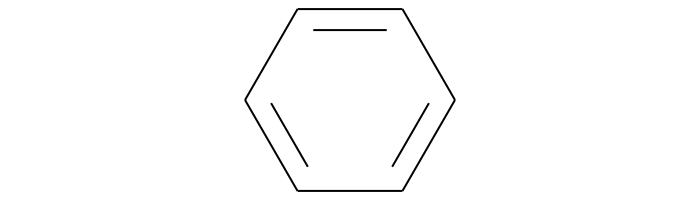

In [69]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole

#@title **Enumerate Stereoisomers to generate ligand topology:**

##@markdown **You can find the smiles for your lingad at: https://pubchem.ncbi.nlm.nih.gov/**

mol= [m for m in pybel.readfile(filename=ligand_pdb2, format='pdb')][0]
mol.calccharges
mol.addh()
out=pybel.Outputfile(filename="temp2.smi",format='smiles',overwrite=True)
out.write(mol)
out.close()

fileObj = open("temp2.smi", "r",) #opens the file in read mode
for aRow in fileObj:
    smi = aRow.split('\t')
fileObj.close()

Ligand_smiles = smi[0] 
!rm temp2.smi >/dev/null 2>&1

mol = Chem.MolFromSmiles(Ligand_smiles)

def spam(n):
    out=[]
    for perm in getPerms(n):
        elem = [ int(i) for i in list(perm) ]
        out.append(elem)
    return out

def getPerms(n):
    from itertools import permutations
    for i in getCandidates(n):
        for perm in set(permutations(i)):
            yield ''.join(perm)

def getCandidates(n):
    for i in range(0, n+1):
        res = "1" * i + "0" * (n - i)
        yield res

def GetStereoIsomers(mol):
    from rdkit import Chem
    from copy import copy
    out = []   

    chiralCentres = Chem.FindMolChiralCenters(mol, includeUnassigned=True)

    #return the molecule object when no chiral centres where identified
    if chiralCentres == []:
        return [mol]

      #All bit permutations with number of bits equals number of chiralCentres
    elements = spam(len(chiralCentres))
    !rm smiles.txt temp2.smi >/dev/null 2>&1
    for isoId,element in enumerate(elements):       
        for centreId,i in enumerate(element):
            atomId = chiralCentres[centreId][0]
            if i == 0:
                mol.GetAtomWithIdx(atomId).SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW)
            elif i == 1:
                mol.GetAtomWithIdx(atomId).SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW)
        outmol = copy(mol)
        out.append(outmol)
        print(Chem.MolToSmiles(mol,isomericSmiles=True), file=open("smiles.txt", "a",))
    return out

Draw.MolsToGridImage(GetStereoIsomers(mol), subImgSize=(500,200), molsPerRow=1)
chiralCentres = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
if chiralCentres != []:
  print("Follow the stereoisomers for your ligand: \n")
  fileObj = open("smiles.txt", "r",) #opens the file in read mode
  smiles = fileObj.read().splitlines() #puts the file into an array
  fileObj.close()
  x = len(smiles[:-1])
  for a in range(x+1):
    y = smiles[0+a:(a+1)]
    globals()[f"isomer{a+1}"] = str(y[0])
    print("Isomer " + str(a+1) + " = " + str(y[0]) + "\n")
else:
  isomer1 = Ligand_smiles
  print("No chiral centres were identified! \nIsomer 1 = " + str(isomer1)  )
Draw.MolsToGridImage(GetStereoIsomers(mol), subImgSize=(700,200), molsPerRow=1, returnPNG=True)

In [70]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from openff.toolkit.typing.engines.smirnoff import ForceField
import parmed

#@title **Parameters to generate the topology:**

#@markdown **Parameters to generate the protein topology:**

Force_field = "ff19SB" #@param ["ff19SB", "ff14SB"]
if Force_field == "ff19SB":
  ff = "leaprc.protein.ff19SB"
else:
  ff = "leaprc.protein.ff14SB"

Water_type = "TIP3P" #@param ["TIP3P", "OPC"]
if Water_type == "TIP3P":
  water = "leaprc.water.tip3p"
  water_box = "TIP3PBOX"
else:
  water = "leaprc.water.opc"
  water_box = "OPCBOX"

#@markdown Size Box (Angstrons):

Size_box = 12 #@param {type:"slider", min:10, max:20, step:1}
size_box = Size_box

#@markdown **ATTENTION**: Give the concentration in Molar units, AMBER tleap will neutralize your system automatically:

Ions = "NaCl" #@param ["NaCl", "KCl" ]

Concentration = "0.15" #@param {type:"string"}

#@markdown **Parameters to generate the ligand topology:**

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

Ligand_isomer = "1" #@param {type:"string", min:1, max:10, step:100}
if chiralCentres == []:
  isomer_end = isomer1
else:
  isomer_end = globals()[f"isomer{Ligand_isomer}"]

Ligand_net_charges = "0" #@param {type:"string", min:-10, max:10, step:1}

#@markdown ---
tleap = os.path.join(workDir, "tleap.in")
top_nw = os.path.join(workDir, "SYS_nw.prmtop")
crd_nw = os.path.join(workDir, "SYS_nw.crd")
pdb_nw = os.path.join(workDir, "SYS_nw.pdb")
top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")
ligand_noh = os.path.join(workDir, "ligand_noh.pdb")
ligand_h = os.path.join(workDir, "ligand_h.pdb")
ligand_mol2 = os.path.join(workDir, "ligand.mol2")
ligand_frcmod = os.path.join(workDir, "ligand.frcmod")
lig_new = os.path.join(workDir, "ligand_gaff.pdb")
protein_ligand = os.path.join(workDir, "protein_ligand.pdb")
lib = os.path.join(workDir, "lig.lib")

#gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command3 = "antechamber -i " + str(ligand_h) + " -fi pdb -o " + str(ligand_mol2) + " -fo mol2 -c bcc -nc " + str(Ligand_net_charges) + " -rn LIG -at gaff2"
gaff_command4 = "parmchk2 -i " + str(ligand_mol2) + " -f mol2 -o " + str(ligand_frcmod) + " -s gaff2"

original_stdout = sys.stdout # Save a reference to the original standard output

with open('gaff.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(gaff_command1)
    print(gaff_command3)
    print(gaff_command4)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 gaff.sh 2>&1 1>/dev/null
!bash gaff.sh >/dev/null 2>&1

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.gaff2
LIG = loadmol2 """ + str(ligand_mol2) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""saveoff LIG """ + str(lib) + "\n"
"""savepdb LIG """ + str(lig_new) + "\n" 
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)
cat_command = "cat " + str(starting_end) + " " + str(lig_new) + str(" > ") + str(protein_ligand)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    print(cat_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

ppdb = PandasPdb().read_pdb(protein_ligand)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['OTHERS'] = [ppdb.df['OTHERS'] != 'OTHERS']
ppdb.to_pdb(path=protein_ligand, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1 
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n" 
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7
saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

SYS = os.path.join(workDir, "SYS*")
rm_sys = "rm " + SYS

original_stdout = sys.stdout # Save a reference to the original standard output

with open('rm_sys.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(rm_sys)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 rm_sys.sh 2>&1 1>/dev/null
!bash rm_sys.sh 2> /dev/null

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null


!grep "Volume:" leap.log > temp.txt
with open("temp.txt", 'r') as f:
  for line in f:
        vol = float(line.split()[1])

vol_lit  = vol * pow(10, -27)
atom_lit = 9.03 * pow(10, 22)
conc = float(Concentration)
num_ion = int(vol_lit * (conc/0.15) * atom_lit)

if Ions == "NaCl":
  pos_neut = "Na+ 0"
  pos_num = "Na+ " + str(num_ion)
  Cl_num = num_ion
else:
  pos_neut = "K+ 0"
  pos_num = "K+ " + str(num_ion)
  Cl_num = num_ion

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1 
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n" 
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
check SYS 
charge SYS
addions SYS """ + str(pos_neut) + "\n"
"""addions SYS Cl- 0
check SYS
charge SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7 """ + "\n"
"""addIonsRand SYS """ + str(pos_num) + """ Cl- """ + str(Cl_num) + "\n"
"""saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()


!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  mol = Chem.MolFromPDBFile(lig_new, removeHs=False)
  Chem.MolToPDBFile(mol, os.path.join(workDir, "ligand_openFF.pdb"))
  
  in_prmtop = top
  in_crd = crd
  orig_structure = parmed.amber.AmberParm(in_prmtop, in_crd)
  pieces = orig_structure.split()
  for piece in pieces:
      print(f"There are {len(piece[1])} instance(s) of {piece[0]}")

  from openmm.app import PDBFile
  from openff.toolkit.topology import Molecule, Topology
  from openff.toolkit.tests.utils import get_data_file_path

  # rdmol = Chem.MolFromMolFile(os.path.join(workDir, "ligand_openFF.sdf"))
  # ligand_off_molecule = Molecule.from_rdkit(rdmol, hydrogens_are_explicit=True)

  ligand_off_molecule = Molecule.from_smiles(isomer_end)
  ligand_pdbfile = PDBFile(os.path.join(workDir, "ligand_openFF.pdb"))
  ligand_off_topology = Topology.from_openmm(
      ligand_pdbfile.topology,
      unique_molecules=[ligand_off_molecule],)

  force_field = ForceField("openff_unconstrained-2.0.0.offxml")

  ligand_system = force_field.create_openmm_system(ligand_off_topology)
  new_ligand_structure = parmed.openmm.load_topology(
      ligand_off_topology.to_openmm(),
      ligand_system,
      xyz=pieces[1][0].positions,)

  new_ligand_structure.save(os.path.join(workDir, "ligand.prmtop"), overwrite=True)
  new_ligand_structure.save(os.path.join(workDir, "ligand.inpcrd"), overwrite=True)

  # Check how many atoms and which order elements are in the new ligand
  n_atoms_new = len(new_ligand_structure.atoms)
  elements_new = [atom.element for atom in new_ligand_structure.atoms]

  # Check how many atoms and which order elements are in the old ligand
  old_ligand_structure, n_copies = pieces[1]
  n_atoms_old = len(old_ligand_structure.atoms)
  elements_old = [atom.element for atom in old_ligand_structure.atoms]

  print(
      f"There are {n_atoms_old} in the old ligand structure and {n_atoms_new} atoms "
      f"in the new ligand structure")

  # Print out error message if number of atoms doesn't match
  if n_atoms_new != n_atoms_old:
      print(
          "Error: Number of atoms in input ligand doesn't match number extracted "
          "from prmtop file.")

  if elements_new != elements_old:
      print(
          "Error: Elements in input ligand don't match elements in the ligand "
          "from the prmtop file.")
      print(f"Old elements: {elements_old}")
      print(f"New elements: {elements_new}")

  # Create a new, empty system
  complex_structure = parmed.Structure()

  # Add the protein. Convert explicitly to an AmberParm object to ensure that 1-4 scaling factors are preserved.
  complex_structure += parmed.amber.AmberParm.from_structure(pieces[0][0])

  # Add the ligand
  complex_structure += parmed.amber.AmberParm.from_structure(new_ligand_structure)

  # Add ions and Waters
  ppdb = PandasPdb().read_pdb(pdb)
  Cl = [ppdb.df['ATOM']['atom_name'] == 'Cl-']
  Na = [ppdb.df['ATOM']['atom_name'] == 'Na+']
  K = [ppdb.df['ATOM']['atom_name'] == 'K+']
  Cl = np.array(Cl)
  Na = np.array(Na)
  K = np.array(K)

  if True in Cl and True in Na:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    just_ion2_structure = parmed.Structure()
    just_ion2_structure += pieces[3][0]
    just_ion2_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)
    complex_structure += parmed.amber.AmberParm.from_structure(just_ion2_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[4][0]
    just_water_structure *= len(pieces[4][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Cl and True in K:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    just_ion2_structure = parmed.Structure()
    just_ion2_structure += pieces[3][0]
    just_ion2_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)
    complex_structure += parmed.amber.AmberParm.from_structure(just_ion2_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[4][0]
    just_water_structure *= len(pieces[4][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Cl:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Na:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in K:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  else: 
    just_water_structure = parmed.Structure()
    just_water_structure += pieces[2][0]
    just_water_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)

  # Copy over the original coordinates and box vectors
  complex_structure.coordinates = orig_structure.coordinates
  complex_structure.box_vectors = orig_structure.box_vectors

  # Export the Structure to AMBER files
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  complex_structure.save(top, overwrite=True)
  complex_structure.save(crd, overwrite=True)
  top_openff = os.path.exists(top)
  crd_openff = os.path.exists(crd)
  if top_openff == True and crd_openff == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")

else:
  pdb_amber = os.path.exists(pdb)
  top_amber = os.path.exists(top)
  crd_amber = os.path.exists(crd)

  if pdb_amber == True and top_amber == True and crd_amber == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")
!!rm *.sh  ANTECHAMBER* ATOMTYPE* temp.txt >/dev/null 2>&1

Successfully generated topology! :-)


[]

In [71]:
#@title ### **Parameters for MD Equilibration protocol:**

# remove whitespaces
Jobname = 'prot_lig_equil' #@param {type:"string"}

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  pdb = os.path.join(workDir, "SYS.pdb")
else:
  top = os.path.join(workDir, "SYS_gaff2.prmtop")
  crd = os.path.join(workDir, "SYS_gaff2.crd")
  pdb = os.path.join(workDir, "SYS.pdb")


Minimization_steps = "20000" #@param ["1000", "5000", "10000", "20000", "50000", "100000"]

#@markdown Simulation time (in nanoseconds) and integration time (in femtoseconds): 
Time = "0.2" #@param {type:"string"}
stride_time_eq = Time
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_eq = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_eq = Temperature
Pressure = 1 #@param {type:"string"}
pressure_eq = Pressure

#@markdown Position restraints force constant (in kJ/mol): 
Force_constant = 700 #@param {type:"slider", min:0, max:2000, step:100}

#@markdown Frequency to write the trajectory file (in picoseconds): 

Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_eq = Write_the_trajectory
#@markdown Frequency to write the log file (in picoseconds): 

Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log


#@markdown ---


In [72]:
#@title **Runs an Equilibration MD simulation (NPT ensemble)**
#@markdown Now, let's equilibrate our system!

###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, Jobname)
coordinatefile = crd
pdbfile = pdb
topologyfile = top

time_ps = float(Time)*1000
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond					
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

pressure	= float(pressure_eq)*bar

restraint_fc = int(Force_constant) # kJ/mol

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

def restraints(system, crd, fc, restraint_array):

	boxlx = system.getDefaultPeriodicBoxVectors()[0][0].value_in_unit(nanometers)
	boxly = system.getDefaultPeriodicBoxVectors()[1][1].value_in_unit(nanometers)
	boxlz = system.getDefaultPeriodicBoxVectors()[2][2].value_in_unit(nanometers)

	if fc > 0:
		# positional restraints for all heavy-atoms
		posresPROT = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2;')
		posresPROT.addPerParticleParameter('k')
		posresPROT.addPerParticleParameter('x0')
		posresPROT.addPerParticleParameter('y0')
		posresPROT.addPerParticleParameter('z0')
  
		for atom1 in restraint_array:
			atom1 = int(atom1)
               
			xpos  = crd.positions[atom1].value_in_unit(nanometers)[0]
			ypos  = crd.positions[atom1].value_in_unit(nanometers)[1]
			zpos  = crd.positions[atom1].value_in_unit(nanometers)[2]

			posresPROT.addParticle(atom1, [fc, xpos, ypos, zpos])
    
		system.addForce(posresPROT)

	return system
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(simulation_time))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps))

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)


print("\t- Applying restraints. Force Constant = " + str(Force_constant) + "kJ/mol")
pt_system = pt.iterload(coordinatefile, topologyfile)
pt_topology = pt_system.top
restraint_array = pt.select_atoms('!(:H*) & !(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+)', pt_topology)

system = restraints(system, inpcrd, restraint_fc, restraint_array)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

print("\t- Energy minimization: " + str(Minimization_steps) + " steps")
simulation.minimizeEnergy(tolerance=10*kilojoule/mole, maxIterations=int(Minimization_steps))
print("\t-> Potential Energy = " + str(simulation.context.getState(getEnergy=True).getPotentialEnergy()))

print("\t- Setting initial velocities...")
simulation.context.setVelocitiesToTemperature(temperature)

#############################################
# Running Equilibration on NPT ensemble

dcd_file = jobname + ".dcd"
log_file = jobname + ".log"
rst_file = jobname + ".rst"
prv_rst_file = jobname + ".rst"
pdb_file = jobname + ".pdb"

# Creating a trajectory file and reporters
dcd = DCDReporter(dcd_file, nsavcrd)
firstdcdstep = (nsteps) + nsavcrd
dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

simulation.reporters.append(dcd)
simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

print("\n> Simulating " + str(nsteps) + " steps...")
simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


##################################
# Writing last frame information of stride
print("\n> Writing state file (" + str(rst_file) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")


> Simulation details:

	Job name = /content/2_1/2_1/prot_lig_equil
	Coordinate file = /content/2_1/2_1/SYS_gaff2.crd
	PDB file = /content/2_1/2_1/SYS.pdb
	Topology file = /content/2_1/2_1/SYS_gaff2.prmtop

	Simulation_time = 200.0 ps
	Integration timestep = 2 fs
	Total number of steps = 100000

	Save coordinates each 10 ps
	Print in log file each 10 ps

	Temperature = 298.0 K
	Pressure = 1.0 bar

> Setting the system:

	- Reading topology and structure file...
	- Creating system and setting parameters...
	- Applying restraints. Force Constant = 700kJ/mol
	- Setting barostat...
	- Setting integrator...
	- Energy minimization: 20000 steps
	-> Potential Energy = -599683.0999956452 kJ/mol
	- Setting initial velocities...

> Simulating 100000 steps...
#"Progress (%)"		"Step"		"Speed (ns/day)"		"Time Remaining"
5.0%		5000		0		--
10.0%		10000		261		0:59
15.0%		15000		270		0:54
20.0%		20000		280		0:49
25.0%		25000		282		0:45
30.0%		30000		287		0:42
35.0%		35000		287		0:39
40.0%		40000		289		0

In [73]:
#@markdown ### **Provide input file names below:** 

Equilibrated_PDB = 'prot_lig_equil.pdb' #@param {type:"string"}
State_file = 'prot_lig_equil.rst' #@param {type:"string"}

#@markdown ---
#@markdown ### **Parameters for MD Production protocol:**


# remove whitespaces
Jobname = 'prot_lig_prod' #@param {type:"string"}

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  pdb = os.path.join(workDir, "SYS.pdb")

else:
  top = os.path.join(workDir, "SYS_gaff2.prmtop")
  crd = os.path.join(workDir, "SYS_gaff2.crd")
  pdb = os.path.join(workDir, "SYS.pdb")


#@markdown Simulation time (in nanoseconds), number of strides (integers) and integration timestep (in femtoseconds): 
Stride_Time = "0.2" #@param {type:"string"}
stride_time_prod = Stride_Time
Number_of_strides = "1" #@param {type:"string"}
nstride = Number_of_strides
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_prod = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_prod = Temperature
Pressure = 1 #@param {type:"string"}
pressure_prod = Pressure

#@markdown Frequency to write the trajectory file (in picoseconds): 
Write_the_trajectory = "100" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_prod = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds): 
Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_prod = Write_the_log

#@markdown ---

In [ ]:
#@title **Runs a Production MD simulation (NPT ensemble) after equilibration**
#
###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, str(Jobname))
coordinatefile = crd
pdbfile = os.path.join(workDir, Equilibrated_PDB)
topologyfile = top
equil_rst_file = os.path.join(workDir, State_file)


stride_time_ps = float(stride_time_prod)*1000
stride_time = float(stride_time_ps)*picosecond        
nstride = int(Number_of_strides)
dt = int(dt_prod)*femtosecond					
temperature = float(temperature_prod)*kelvin
savcrd_freq = int(write_the_trajectory_prod)*picosecond
print_freq  = int(write_the_log_prod)*picosecond

pressure	= float(pressure_prod)*bar

simulation_time = stride_time*nstride
nsteps  = int(stride_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
firststride = 1 # must be integer
#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(stride_time*nstride))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps*nstride))
print("\tNumber of strides = " + str(nstride) + " (" + str(stride_time) + " in each stride)")

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tSave checkpoint each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
	simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

#############################################
# Opening a loop of extension NSTRIDE to simulate the entire STRIDE_TIME*NSTRIDE
for n in range(1, nstride + 1):

	print("\n\n>>> Simulating Stride #" + str(n) + " <<<")

	dcd_file = jobname + "_" + str(n) + ".dcd"
	log_file = jobname + "_" + str(n) + ".log"
	rst_file = jobname + "_" + str(n) + ".rst"
	prv_rst_file = jobname + "_" + str(n-1) + ".rst"
	pdb_file = jobname + "_" + str(n) + ".pdb"

	if os.path.exists(rst_file):
		print("> Stride #" + str(n) + " finished (" + rst_file + " present). Moving to next stride... <")
		continue

	if n == 1:
		print("\n> Loading previous state from equilibration > " + equil_rst_file + " <")
		with open(equil_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")

	else:
		print("> Loading previous state from > " + prv_rst_file + " <")
		with open(prv_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")


	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (currstep) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # first step should not be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=(nsteps*nstride), remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

	print("\n> Simulating " + str(nsteps) + " steps... (Stride #" + str(n) + ")")
	simulation.step(nsteps)

	simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


	##################################
	# Writing last frame information of stride
	print("\n> Writing state file (" + str(rst_file) + ")...")
	state = simulation.context.getState( getPositions=True, getVelocities=True )
	with open(rst_file, 'w') as f:
		f.write(XmlSerializer.serialize(state))

	last_frame = int(nsteps/nsavcrd)
	print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
	positions = simulation.context.getState(getPositions=True).getPositions()
	PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")


> Simulation details:

	Job name = /content/2_1/2_1/prot_lig_prod
	Coordinate file = /content/2_1/2_1/SYS_gaff2.crd
	PDB file = /content/2_1/2_1/prot_lig_equil.pdb
	Topology file = /content/2_1/2_1/SYS_gaff2.prmtop

	Simulation_time = 200.0 ps
	Integration timestep = 2 fs
	Total number of steps = 100000
	Number of strides = 1 (200.0 ps in each stride)

	Save coordinates each 100 ps
	Save checkpoint each 100 ps
	Print in log file each 10 ps

	Temperature = 298.0 K
	Pressure = 1.0 bar

> Setting the system:

	- Reading topology and structure file...
	- Creating system and setting parameters...
	- Setting barostat...
	- Setting integrator...


>>> Simulating Stride #1 <<<

> Loading previous state from equilibration > /content/2_1/2_1/prot_lig_equil.rst <
> Current time: 0.0 ps (Step = 0)

> Simulating 100000 steps... (Stride #1)
#"Progress (%)"		"Step"		"Speed (ns/day)"		"Time Remaining"
5.0%		5000		0		--
10.0%		10000		274		0:56
15.0%		15000		295		0:49
20.0%		20000		302		0:45
25.0%		250

In [ ]:
#@title **Concatenate and align the trajectory**
Skip = "1" #@param ["1", "2", "5", "10", "20", "50"]
stride_traj = Skip
Output_format = "dcd" #@param ["dcd", "pdb", "trr", "xtc"]

#@markdown **Attention:** A high number of frames can explode the memory on Colab. You should be fine with 5000 frames or less.

simulation_time_analysis = stride_time_ps*nstride
simulation_ns = float(Stride_Time)*int(Number_of_strides)
number_frames = int(simulation_time_analysis)/int(Write_the_trajectory)
number_frames_analysis = number_frames/int(stride_traj)


traj_end = os.path.join(workDir, str(Jobname) + "_all.dcd")
traj_end2 = os.path.join(workDir, str(Jobname) + "_all." + str(Output_format))
template =  os.path.join(workDir, str(Jobname) + '_%s.dcd')

flist = [template % str(i) for i in range(1, nstride + 1)]
#print(flist)

trajlist = pt.load(flist, pdb, stride=stride_traj)
traj_image = trajlist.iterframe(autoimage=True, rmsfit=0)
traj_write = pt.write_traj(traj_end, traj_image, overwrite=True)
traj_load = pt.load(traj_end, pdb)
traj_align = pt.align(traj_load, mask="@CA", ref=0) 
traj_write = pt.write_traj(traj_end, traj_align, overwrite=True, options='dcd')
traj_write = pt.write_traj(traj_end2, traj_align, overwrite=True, options=Output_format)
traj_load = pt.load(traj_end, os.path.join(workDir, "SYS_gaff2.prmtop"))
print(traj_load)


traj_end_check = os.path.exists(traj_end2)

if traj_end_check == True:
  print("Trajectory concatenated successfully! :-)")
else:
  print("ERROR: Check your inputs! ")

In [ ]:
#@title **MM-PBSA method to calculate the binding free energy**
#@markdown **Important:** We will now calculate the interaction energy and solvation free energy for the complex, receptor and ligand and average the results to obtain an estimate of the binding free energy. Please note that we will not perform a calculation of the entropy contribution to binding and so strictly speaking our result will not be a true free energy but could be used to compare against similar systems. We will carry out the binding energy calculation using both the MM-GBSA method and the MM-PBSA method for comparison.

#@markdown Select the GB/SA input parameters,  the "OBC" models (igb=2 and 5) are newer, but appear to give significant improvements and are recommended for most projects (For more information check the Section 4.1 of the [Amber Manual](https://ambermd.org/doc12/Amber20.pdf)):
igb = "2" #@param ["0", "1", "2", "5", "6", "7", "8", "10"]

Salt_concentration = '0.15' #@param {type:"string"}

#@markdown **Provide output file names below:** 
Output_name = 'FINAL_RESULTS_MMPBSA' #@param {type:"string"}

final_mmpbsa = os.path.join(workDir, Output_name)

if number_frames_analysis > 10:
  stride = number_frames_analysis/10
else:
  stride = 1

f = open("mmpbsa.in", "w")
f.write("""&general """  + "\n"
"""  endframe=""" + str(int(number_frames_analysis)) + """,  interval=""" + str(int(stride)) + """, strip_mask=:WAT:Na+:Cl-:Mg+:K+, """ + "\n"
"""/ """ + "\n"
"""&gb """ + "\n"
""" igb=""" + str(igb) +  """, saltcon=""" + str(Salt_concentration) +  """, """ + "\n"
"""/ """ + "\n"
"""&pb """ + "\n"
""" istrng=""" + str(Salt_concentration) +  """, inp=2, radiopt=0, prbrad=1.4, """ + "\n"
"""/""")
f.close()

amberhome = "source /usr/local/amber.sh"
ante_MMPBSA = "ante-MMPBSA.py  -p " + os.path.join(workDir, "SYS_gaff2.prmtop") + " -c com.prmtop -r rec.prmtop -l ligand.prmtop -s :WAT:Na+:Cl-:Mg+:K+ -n :LIG --radii mbondi2" 
MMPBSA = "MMPBSA.py -O -i mmpbsa.in -o " + str(final_mmpbsa) +  ".dat -sp " + os.path.join(workDir, "SYS_gaff2.prmtop") + " -cp com.prmtop -rp rec.prmtop -lp ligand.prmtop -y "  + str(traj_end)
mkdir = "mkdir " + os.path.join(workDir, "MMPBSA")
mv = "mv _MMPBSA* *.prmtop reference.frc mmpbsa.in " + os.path.join(workDir, "MMPBSA")

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_MMPBSA.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(amberhome)
    print(ante_MMPBSA)
    print(MMPBSA)
    print(mkdir)
    print(mv)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_MMPBSA.sh 2>&1 1>/dev/null
!bash run_MMPBSA.sh 2>&1 1>/dev/null

f_mmpbsa = open(final_mmpbsa + '.dat', 'r')
file_contents = f_mmpbsa.read()
print(file_contents)
f_mmpbsa.close()